In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

Por obvios motivos esto ya no funciona, era un db de prueba

In [8]:
from pymongo import MongoClient

HOST="clase.2axjvot.mongodb.net"
PORT=27017
USERNAME="nicolas"
PASSWORD="YS9v3DIbkoTMQUxL"

def get_dataframe (filename:str = None) -> pd.DataFrame:
    if filename is None:
        if HOST == 'localhost':
            if not USERNAME:
                cli_mongo = MongoClient(HOST, PORT)
            else:
                cli_mongo = MongoClient(HOST, PORT, USERNAME, PASSWORD)
        else:
            cli_mongo = MongoClient(f"mongodb+srv://{USERNAME}:{PASSWORD}@{HOST}")  
        
        cursor = cli_mongo["sbd"]["covid_italia"].find({})
        df = pd.DataFrame(list(cursor))
        df.drop(["_id"],axis=1,inplace=True)
    
    else: df = pd.read_json(filename)
    return df

In [9]:
df = get_dataframe("archives/sbd.covid_italia.json")
df['data'] = pd.to_datetime(df['data'], format="ISO8601")  
df.head()

,data,stato,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,totale_casi,note,codice_nuts_1,codice_nuts_2,codice_nuts_3
0,2020-02-24 18:00:00,ITA,13,Abruzzo,66,L'Aquila,AQ,42.351222,13.398438,0,None,None,None,None
1,2020-02-24 18:00:00,ITA,13,Abruzzo,67,Teramo,TE,42.658918,13.704400,0,None,None,None,None
2,2020-02-24 18:00:00,ITA,13,Abruzzo,68,Pescara,PE,42.464584,14.213648,0,None,None,None,None
3,2020-02-24 18:00:00,ITA,13,Abruzzo,69,Chieti,CH,42.351032,14.167546,0,None,None,None,None
4,2020-02-24 18:00:00,ITA,13,Abruzzo,979,In fase di definizione/aggiornamento,None,NaN,NaN,0,None,None,None,None


- Dende Python, conecta coa máquina que ten o dataset de COVID de Italia.
- Carga o dataset nun DataFrame de PANDAS (podes empregar o código da práctica anterior).
    - Debuxa 4 gráficos DIFERENTES (de diferente tipo) con SeaBorn relacionando variables entre eles que queden vistosos e xeitosos. Lembra:
    - Alomenos un deles ten que ser de dispersión entre dúas variables.
    - Pon un theme e un palette distinto en cada gráfico.

In [10]:
# Creo un nuevo dataframe donde coloco solo los valores que me interesan
df_r = pd.DataFrame(df["data"])
df_r.insert(1,"year",df["data"].dt.year.astype(np.int64))
df_r.insert(2,"month",df["data"].dt.month.astype(np.int64))
df_r.insert(3,"total_cases",df["totale_casi"].astype(np.int64))
df_r.insert(4,"region",df["denominazione_regione"])

# Scatter + Lineplot

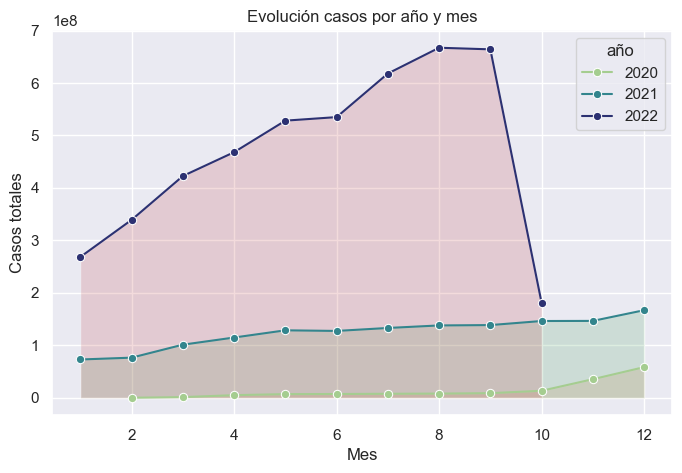

In [11]:
# Los agrupo para poder hacer la tabla por año y mes 
df_aux = pd.DataFrame(df_r.groupby(["year","month"])['total_cases'].sum())
df_aux.reset_index(inplace=True)

# Estilo de la gráfica y creación
plt.figure(figsize=(8,5))
sns.set_theme(style="darkgrid")

sns.scatterplot(data=df_aux, 
                x="month", y="total_cases")

sns.lineplot(data=df_aux, 
             x="month", y="total_cases", hue="year", 
             marker="o", palette="crest")

# Relleno los espacios para mejorar la visualización
for year in df_aux["year"].unique():
    fill = df_aux[df_aux["year"]==year]
    plt.fill_between(x=fill["month"],y1=fill["total_cases"], 
                     alpha=0.2)
    
plt.xlabel("Mes")
plt.ylabel("Casos totales")
plt.title("Evolución casos por año y mes")
plt.legend(title="año")

# Catplot

c:\Users\nicolas.portossaaved\AppData\Local\miniconda3\envs\bigdata\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


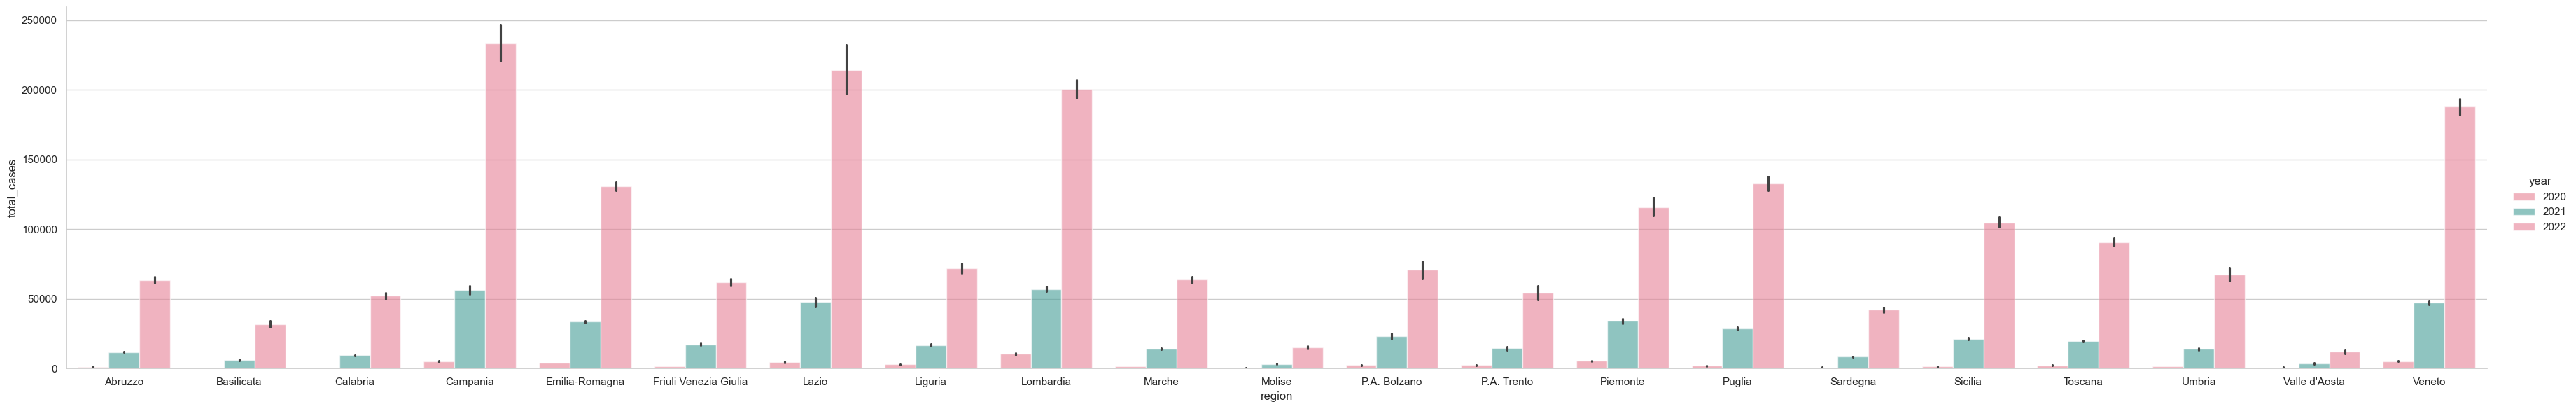

In [12]:
sns.set_theme(style="whitegrid")
sns.catplot(data=df_r, kind="bar",
            x="region", y="total_cases", hue="year",
            palette="husl", alpha=.6, height=6, aspect=6)

# Boxplot

Text(0, 0.5, 'Casos totales')

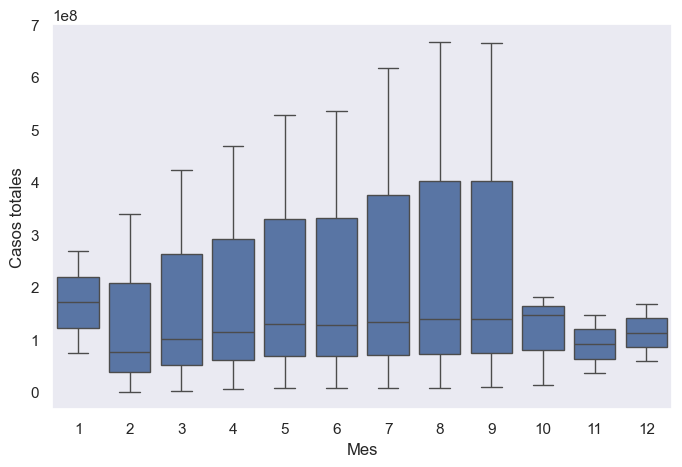

In [13]:
# Los agrupo para poder hacer la tabla por año y mes 
df_aux = pd.DataFrame(df_r.groupby(["year","month"])['total_cases'].sum())
df_aux.reset_index(inplace=True)

# Estilo de la gráfica y creación
plt.figure(figsize=(8,5))
sns.set_theme(style="dark")

sns.boxplot(data=df_aux, 
            x="month", y="total_cases")
    
plt.xlabel("Mes")
plt.ylabel("Casos totales")


# JointGrid

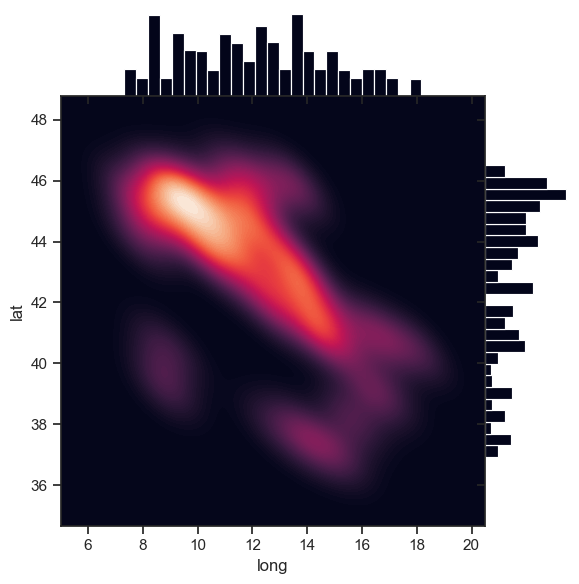

In [14]:
sns.set_theme(style="ticks", palette="muted")

g = sns.JointGrid(data=df[:2000], x="long", y="lat", space=0)
g.plot_joint(sns.kdeplot,
             fill=True,thresh=0, levels=100,
             cmap="rocket")
g.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=25)

# Basemap

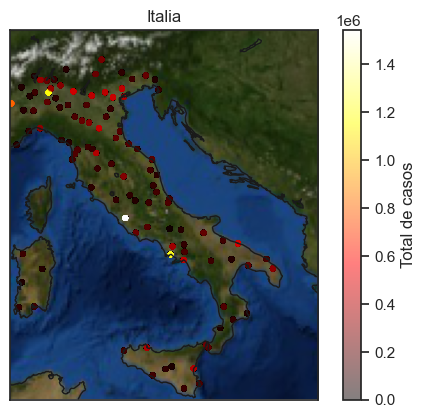

In [16]:
from mpl_toolkits.basemap import Basemap

m = Basemap(projection="cass",
            resolution="i",
            lat_0=42,
            lon_0=14,
            width=1E6,
            height=1.2E6)

m.drawlsmask(land_color = "#ddaa66", 
             ocean_color= "#7777ff",
             resolution = 'i')
m.bluemarble()
m.drawcoastlines()

x, y = m(df['long'].values, df['lat'].values)

mappable = m.scatter(x, y, c=df['totale_casi'], 
                     alpha=0.5, s=10, cmap="hot")

plt.colorbar(mappable, label='Total de casos')
plt.title("Italia")
plt.show()